# D213 Task 1 Rev 3 - Mattinson

## Update & install

## import packages & read data

### import packages

In [1]:
#import basic libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from scipy import signal

In [2]:
# import and configure matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

In [3]:
# import required model libraries
from statsmodels.tsa.stattools import acf, pacf
#from statsmodels.tsa.arima.model import ARIMA
import statsmodels.tsa.stattools as ts
#from statsmodels.tsa.arima_model import ARIMA2
from statsmodels.tsa.arima.model import ARIMA

In [4]:
# Where to save figures and model diagrams
# adapted code (Geron, 2019)
import os
IMAGES_PATH = os.path.join(".", "figures")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print('Saving figure: {}'.format(fig_id))
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, 
        dpi=resolution, bbox_inches = "tight")
    
MODEL_PATH = os.path.join(".", "models")
os.makedirs(MODEL_PATH, exist_ok=True)   

TABLE_PATH = os.path.join(".", "tables")
os.makedirs(TABLE_PATH, exist_ok=True) 

DATA_PATH = os.path.join(".", "data")
os.makedirs(DATA_PATH, exist_ok=True)

### read time data

In [5]:
def read_time_series(file: str, index: str, start_date=None, freq='d') -> pd.DataFrame():
    """create dataframe of time series data
    Author: Mike Mattinson
    Date: June 22, 2022
    
    Parameters
    ----------
    file: str
       filename of time series data
    index: str
       column name of date index
    start_date: datetime
       (optional) if using specific start date
    freq: str
       (default) '24H' 24-hour increments
    
    Returns
    -------
    tsdf: pd.DataFrame()
       time series dataframe
    
    """
    
    # read and initialize index
    tsdf =  pd.read_csv(file)
    tsdf.set_index(index, inplace=True)
    
    # re-index on specific optional start_date
    index_label = 'Date'
    if(start_date is not None):
        tsdf[index_label] = (pd.date_range(
            start=start_date,
            periods=tsdf.shape[0],
            freq=freq))
        tsdf.set_index(index_label, inplace=True)
        tsdf['Year'] = tsdf.index.year
        tsdf['Month'] = tsdf.index.month
        #tsdf['Weekday Name'] = tsdf.index.weekday_name
                    
    # print out summary
    print(tsdf.info())
    print(tsdf.shape)
    print(tsdf.sample(5, random_state=0))
    
    return tsdf # time series dataframe

In [6]:
# read time series data from CSV file
from datetime import datetime
df =  read_time_series(
    file='data/teleco_time_series.csv', 
    index='Day', freq='d', 
    start_date=datetime(2020,1,1)
)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 730 entries, 2020-01-01 to 2021-12-30
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Revenue  730 non-null    float64
 1   Year     730 non-null    int64  
 2   Month    730 non-null    int64  
dtypes: float64(1), int64(2)
memory usage: 22.8 KB
None
(730, 3)
              Revenue  Year  Month
Date                              
2020-07-15   5.328601  2020      7
2020-07-06   5.816199  2020      7
2020-01-15   1.085547  2020      1
2020-02-01   2.442888  2020      2
2021-01-25  11.234359  2021      1


## clean & explore data

In [7]:
# show sample from dataframe
n_rows=10
df.sample(n_rows, random_state=0)

,Revenue,Year,Month
Date,,,
2020-07-15,5.328601,2020,7
2020-07-06,5.816199,2020,7
2020-01-15,1.085547,2020,1
2020-02-01,2.442888,2020,2
2021-01-25,11.234359,2021,1
2020-11-15,9.039982,2020,11
2020-10-26,9.647130,2020,10
2021-12-03,15.709684,2021,12
2021-04-07,11.829173,2021,4


In [8]:
# drop zero values
df= df[df['Revenue'] != 0]

In [9]:
# descripe numerical data
df.describe()

,Revenue,Year,Month
count,729.000000,729.000000,729.000000
mean,9.849038,2020.499314,6.519890
std,3.825359,0.500343,3.444609
min,0.000793,2020.000000,1.000000
25%,6.916245,2020.000000,4.000000
50%,10.804153,2020.000000,7.000000
75%,12.568041,2021.000000,10.000000
max,18.154769,2021.000000,12.000000


In [10]:
#find rolling mean of previous n periods
n_days = 30
df['rolling_mean'] = df['Revenue'].rolling(window=n_days).mean()
df['rolling_std'] = df['Revenue'].rolling(window=n_days).std()

In [11]:
#check missing data
df.isnull().any()

Revenue         False
Year            False
Month           False
rolling_mean     True
rolling_std      True
dtype: bool

### export cleaned data

In [12]:
# export cleaned data to file
df.to_csv('tables\cleaned.csv', index=True, header=True)
print(df.info())
print(df.shape)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 729 entries, 2020-01-02 to 2021-12-30
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Revenue       729 non-null    float64
 1   Year          729 non-null    int64  
 2   Month         729 non-null    int64  
 3   rolling_mean  700 non-null    float64
 4   rolling_std   700 non-null    float64
dtypes: float64(3), int64(2)
memory usage: 34.2 KB
None
(729, 5)


### revenue plot with polyfit regression

https://stackoverflow.com/questions/39801403/how-to-derive-equation-from-numpys-polyfit

In [13]:
# equation of poly fit 
from sympy import S, symbols, printing
x = pd.Series(range(df.shape[0]))
y = df['Revenue'].values
n_deg = 3
p = np.polyfit(x, y, deg=n_deg)
f = np.poly1d(p)
e = symbols("x")
poly = sum(S("{:6.7f}".format(v))*e**i for i, v in enumerate(p[::-1]))
eq_latex = printing.latex(poly)
print(p)
print(poly) # won't include zero terms

[ 4.51657462e-08 -6.81697467e-05  4.45492435e-02  1.32180215e+00]
-6.82e-5*x**2 + 0.0445492*x + 1.3218021


Saving figure: Revenue ($M)


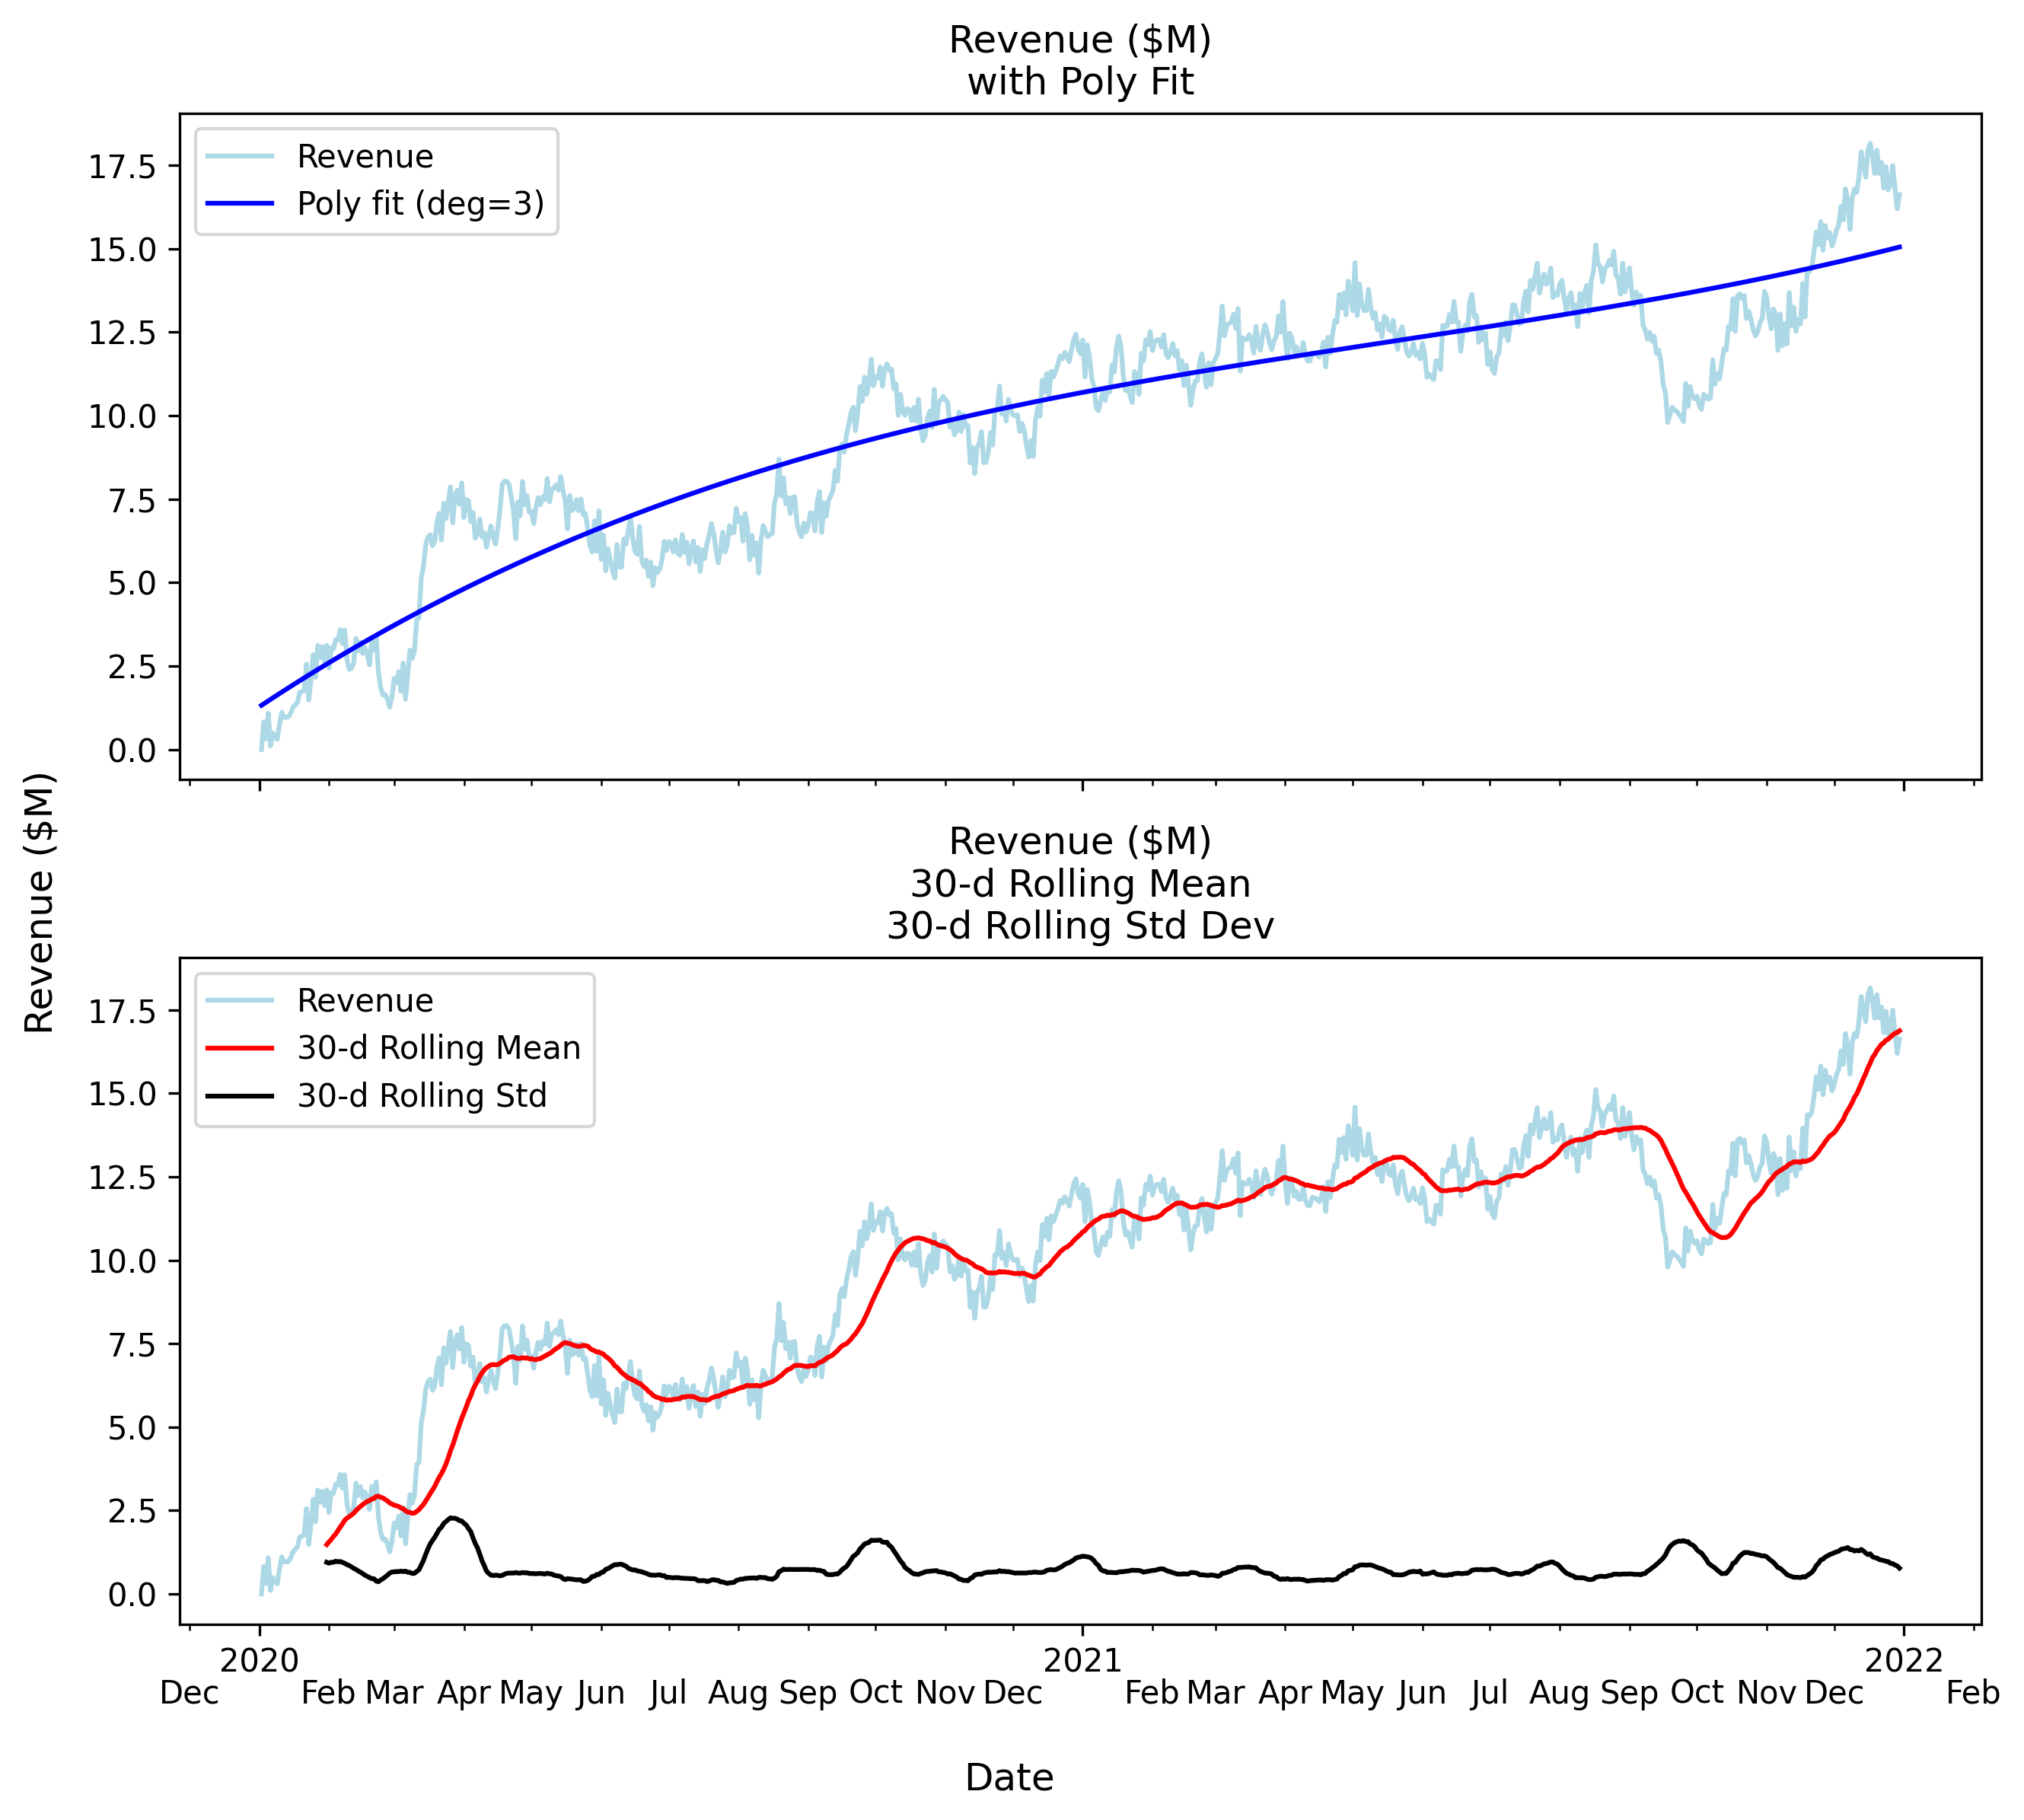

In [14]:
# visualize raw revenue data
x = pd.Series(df.index.values) # if using date
x2 = pd.Series(range(df.shape[0])) # if using date index
fig, ax = plt.subplots(2,1, figsize = (9, 8), sharex=True, sharey=True)
ax[0].plot(x, df.Revenue, 'lightblue', label='Revenue')
ax[1].plot(x, df.Revenue, 'lightblue', label='Revenue')
ax[0].plot(x,f(x2),"b", label='Poly fit (deg=' + str(n_deg) + ')')
ax[0].legend()
ax[0].set_title('Revenue ($M)\nwith Poly Fit')
ax[1].plot(x,df['rolling_mean'], "red",
         label=str(n_days) + '-d Rolling Mean')
ax[1].plot(x,df['rolling_std'], "black", 
         label=str(n_days) + '-d Rolling Std')
ax[1].set_title('Revenue ($M)\n30-d Rolling Mean\n30-d Rolling Std Dev')
ax[1].legend()
import matplotlib.dates as mdates
ax[1].xaxis.set_major_locator(mdates.YearLocator())
ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax[1].xaxis.set_minor_locator(mdates.MonthLocator())
ax[1].xaxis.set_minor_formatter(mdates.DateFormatter('\n%b'))
fig.supxlabel('Date') # common x label
fig.supylabel('Revenue ($M)') # common y label
#plt.gcf().text(0, -.1, "${}$".format(eq_latex), fontsize=14)
title = 'Revenue ($M)'
save_fig(title) 

Generally, trending up and not stationary. Also, does not appear to have seasonality.

## diff data - make stationary

### dickey-fuller - on raw data, non-stationary data

https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html

https://machinelearningmastery.com/time-series-data-stationary-python/ 

https://www.machinelearningplus.com/time-series/augmented-dickey-fuller-test/

https://www.quora.com/What-is-an-Augmented-Dickey-Fuller-test

In [15]:
import statsmodels.tsa.stattools as ts
def dickey_fuller(
    array: np.array, 
    critical=0.05,
    stats=False) -> float:
    """return p-value of augmented dickey-fullter test
    Author: Mike Mattinson
    Date: June 29, 2022
    
    Parameters
    ----------
    array: np.array # array-like
       array of values to be evaluated
    critical: float (default=0.05)
       critical value
    stats: bool (default=False)
        include stats is output or not
    
    Returns
    -------
    pvalue: float
        p-value

    """
    result = ts.adfuller(array, autolag='AIC')
    pvalue = result[1]
    
    if(stats):
        print('ADF Statistic: %f' % result[0])
        print('p-value: %f' % pvalue)
        print('Critical Values:')
        for key, value in result[4].items():
            print('\t%s: %.3f' % (key, value))
    
    if pvalue <= critical:
        print('Reject H0, data is stationary.')
    else:
        print('Accept H0, data is non-stationary.')
    
    return pvalue

In [16]:
# augmented dickey-fuller
dickey_fuller(df['Revenue'].values, stats=True)

ADF Statistic: -1.787175
p-value: 0.386847
Critical Values:
	1%: -3.439
	5%: -2.866
	10%: -2.569
Accept H0, data is non-stationary.


0.3868472463695337

https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.diff.html

In [17]:
"""Calculates difference of Dataframe element compared with another 
element in the Dataframe (default is element in previous row)."""
df_stationary = df.diff(periods=1,axis=0).dropna()
print(df_stationary.info())
print(df_stationary.shape)
#print(df_stationary.describe())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 699 entries, 2020-02-01 to 2021-12-30
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Revenue       699 non-null    float64
 1   Year          699 non-null    float64
 2   Month         699 non-null    float64
 3   rolling_mean  699 non-null    float64
 4   rolling_std   699 non-null    float64
dtypes: float64(5)
memory usage: 32.8 KB
None
(699, 5)


### dickey-fuller - on differenced data

In [18]:
# augmented dickey-fuller
dickey_fuller(df_stationary['Revenue'].values,
        stats=True)

ADF Statistic: -43.503317
p-value: 0.000000
Critical Values:
	1%: -3.440
	5%: -2.866
	10%: -2.569
Reject H0, data is stationary.


0.0

### export stationary data

In [19]:
# export stationary data to file
df_stationary.to_csv('tables\stationary.csv', index=True, header=True)
print(df_stationary.info())
print(df_stationary.shape)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 699 entries, 2020-02-01 to 2021-12-30
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Revenue       699 non-null    float64
 1   Year          699 non-null    float64
 2   Month         699 non-null    float64
 3   rolling_mean  699 non-null    float64
 4   rolling_std   699 non-null    float64
dtypes: float64(5)
memory usage: 32.8 KB
None
(699, 5)


## train test split

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [20]:
# use last 30 days for testing
train = df.iloc[:-30]
test = df.iloc[-30:]
print('training: {}'.format(train.shape))
print('testing: {}'.format(test.shape))

training: (699, 5)
testing: (30, 5)


In [21]:
test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 30 entries, 2021-12-01 to 2021-12-30
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Revenue       30 non-null     float64
 1   Year          30 non-null     int64  
 2   Month         30 non-null     int64  
 3   rolling_mean  30 non-null     float64
 4   rolling_std   30 non-null     float64
dtypes: float64(3), int64(2)
memory usage: 1.4 KB


In [22]:
test.describe()

,Revenue,Year,Month,rolling_mean,rolling_std
count,30.000000,30.0,30.0,30.000000,30.000000
mean,16.872285,2021.0,12.0,15.542414,1.154139
std,0.775838,0.0,0.0,1.028714,0.182229
min,15.269829,2021.0,12.0,13.823538,0.775838
25%,16.464367,2021.0,12.0,14.632974,1.005811
50%,16.812698,2021.0,12.0,15.680083,1.217149
75%,17.468064,2021.0,12.0,16.501241,1.304027
max,18.154769,2021.0,12.0,16.872285,1.393714


In [23]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 699 entries, 2020-01-02 to 2021-11-30
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Revenue       699 non-null    float64
 1   Year          699 non-null    int64  
 2   Month         699 non-null    int64  
 3   rolling_mean  670 non-null    float64
 4   rolling_std   670 non-null    float64
dtypes: float64(3), int64(2)
memory usage: 32.8 KB


In [24]:
train.describe()

,Revenue,Year,Month,rolling_mean,rolling_std
count,699.000000,699.000000,699.000000,670.000000,670.000000
mean,9.547611,2020.477825,6.284692,9.629479,0.752977
std,3.609195,0.499866,3.321016,3.283875,0.340879
min,0.000793,2020.000000,1.000000,1.479869,0.320378
25%,6.780703,2020.000000,3.000000,6.897889,0.567705
50%,10.584897,2020.000000,6.000000,10.678350,0.654518
75%,12.389034,2021.000000,9.000000,12.300972,0.812071
max,15.814725,2021.000000,12.000000,13.982189,2.282856


## spectral density

https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.periodogram.html

https://www.geeksforgeeks.org/plot-the-power-spectral-density-using-matplotlib-python/

https://online.stat.psu.edu/stat510/lesson/12/12.1

https://web.stanford.edu/class/earthsys214/notes/series.html


In [25]:
from scipy import signal
def sd_plot(data, target, ax, i: int, title: str) -> None:
    f, Pxx = signal.periodogram(data[target])
    ax[i].semilogy(f, Pxx, label='data')
    ax[i].set_title(title)
    ax[i].hlines(y=10e-1, xmin=0, xmax=0.5, lw=1, 
                 linestyles='--', color='r', label='10e-1')
    ax[i].set_ylim([1e-6, 1e2])
    ax[i].legend()
    return None

Saving figure: Spectral Density


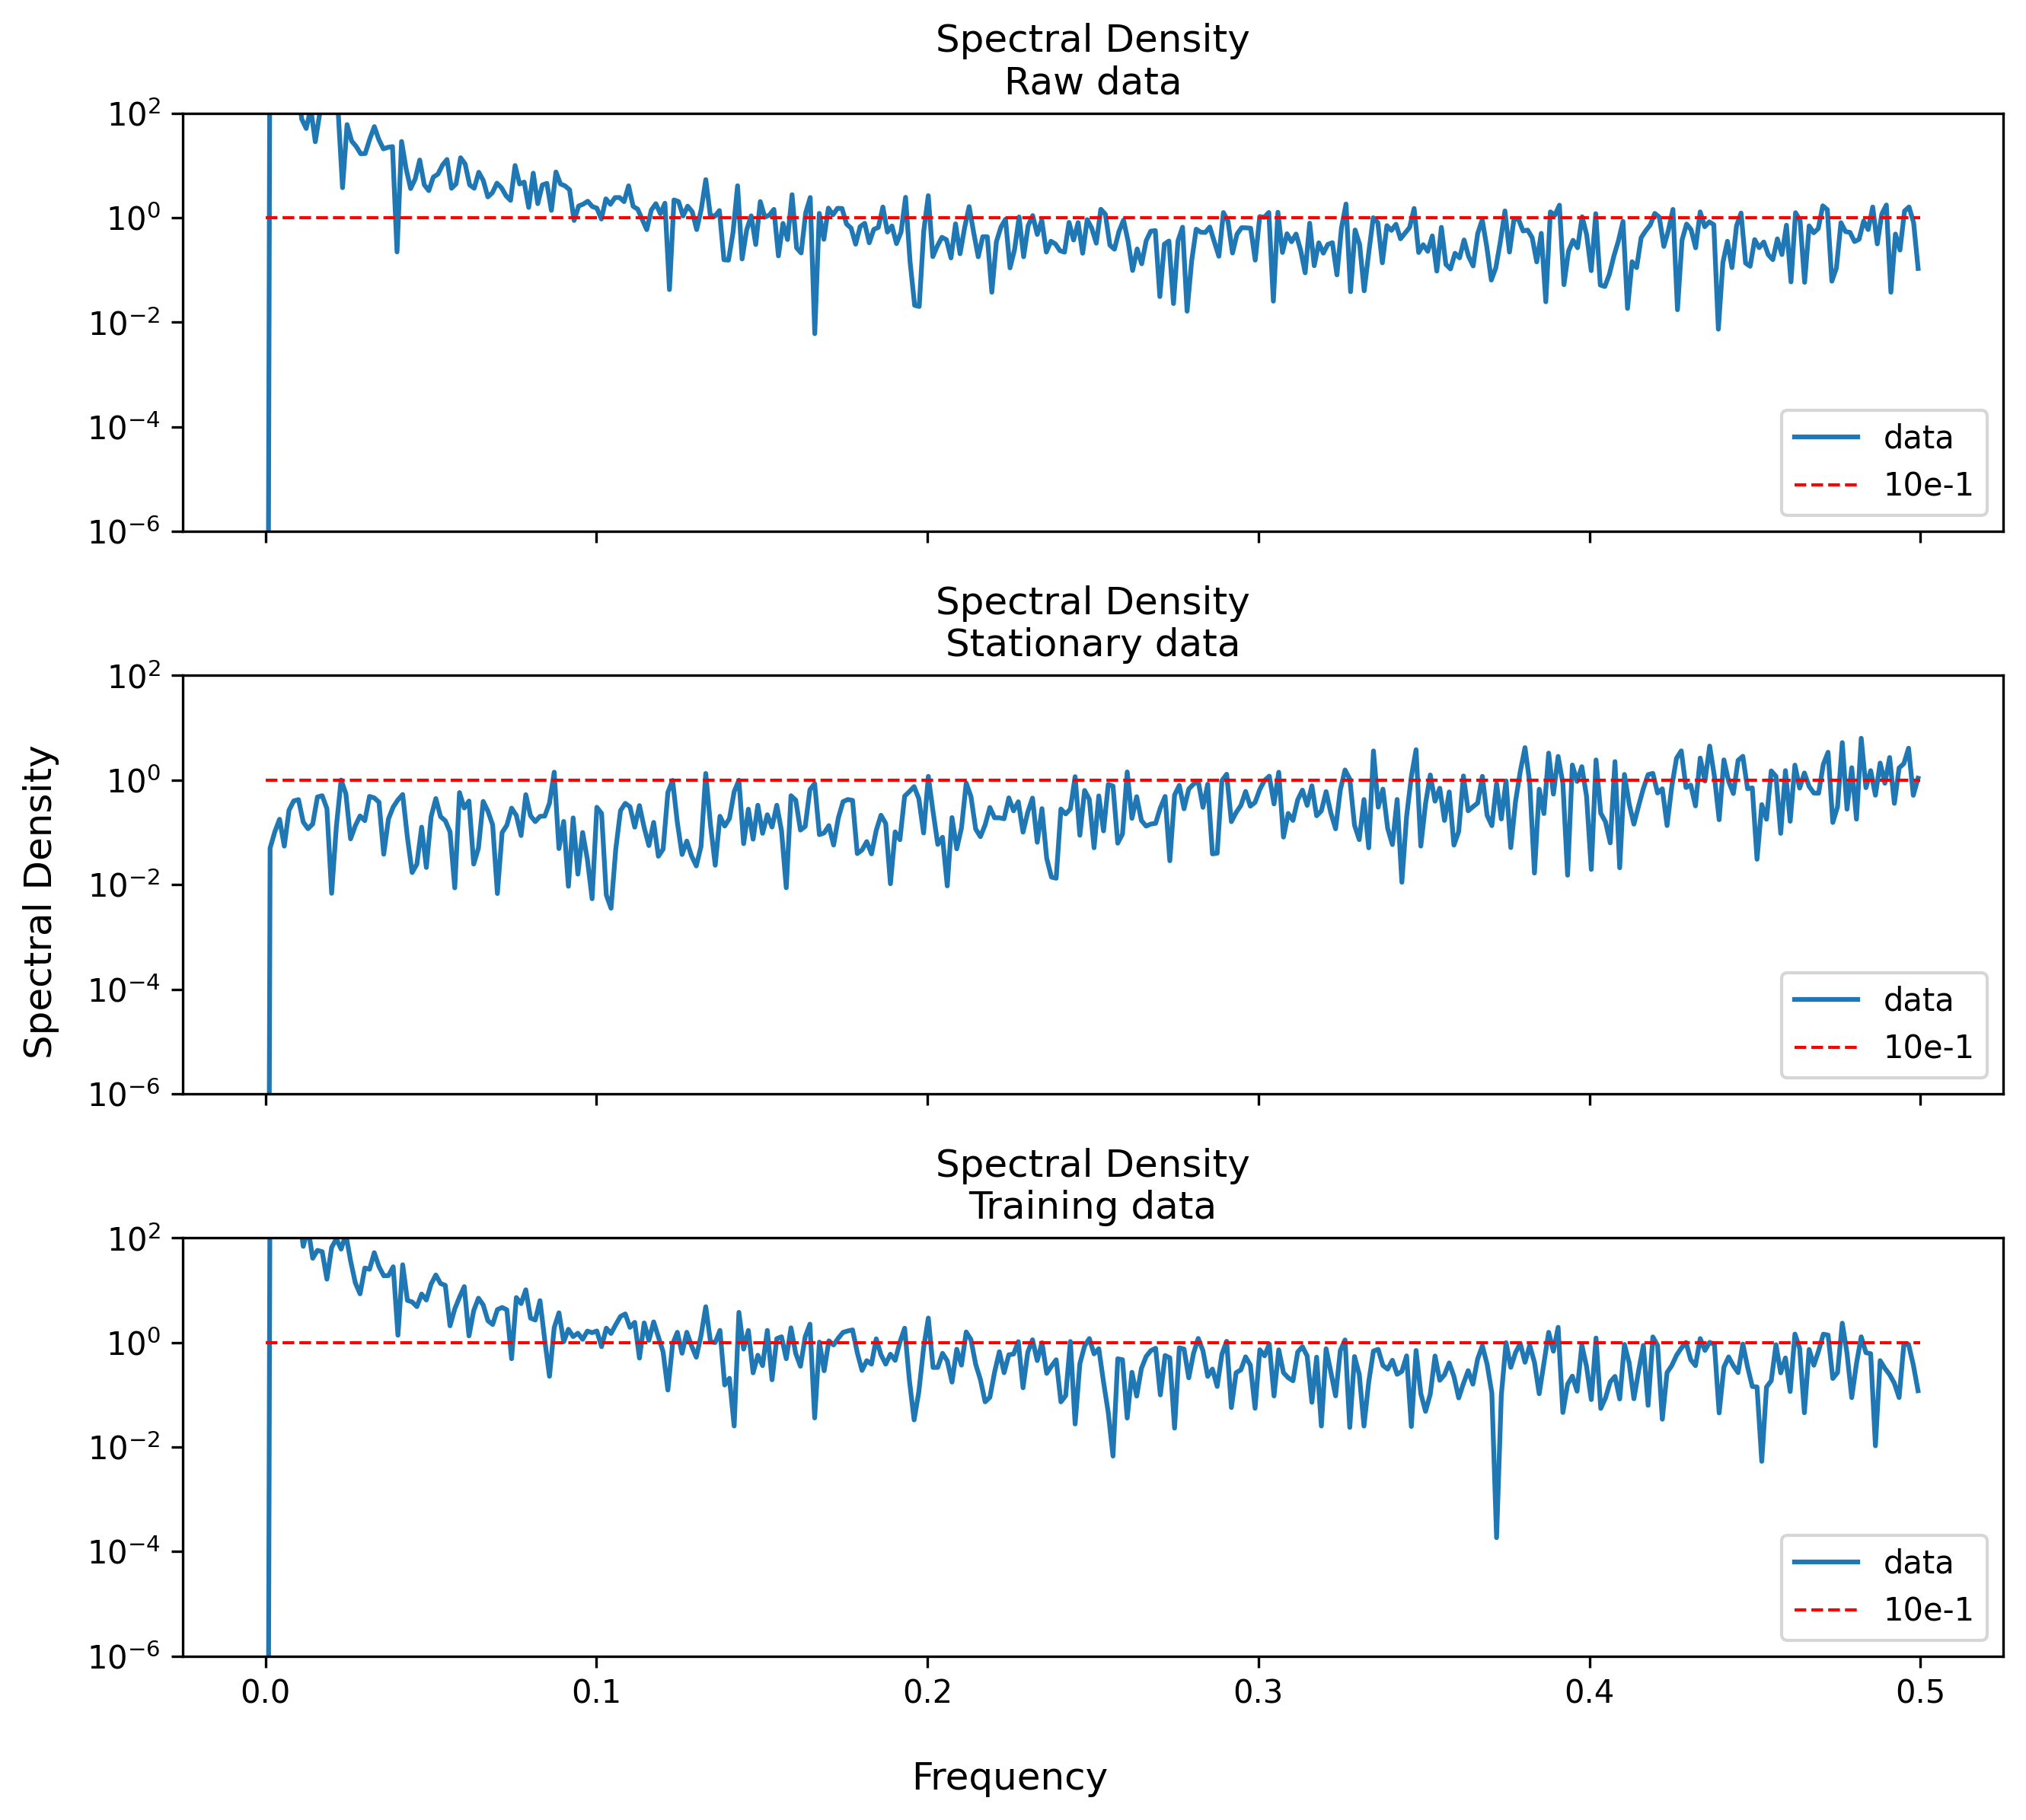

In [26]:
# plot spectral density
fig, ax = plt.subplots(3,1, figsize = (9, 8), sharex=True, sharey=True)
sd_plot(data=df, target='Revenue', ax=ax, i=0,
         title='Spectral Density\nRaw data')
sd_plot(data=df_stationary, target='Revenue', ax=ax, i=1,
         title='Spectral Density\nStationary data')
sd_plot(data=train, target='Revenue', ax=ax, i=2,
         title='Spectral Density\nTraining data')
title = 'Spectral Density'
fig.supxlabel('Frequency') # common x label
fig.supylabel('Spectral Density') # common y label
save_fig(title) 

## acf & pacf plots

In [27]:
from statsmodels.tsa.stattools import acf
def acf_plot(data, target, ax, i: int, conf: bool, title: str) -> None:
    
    acf_values = acf((data[target].values))
    acf_df = pd.DataFrame([acf_values]).T
    acf_df.columns = ['ACF']
    ax[i].plot(acf_df.ACF, 'b-', label='data')
    if(conf):
        ax[i].hlines(y=0.05, xmin=0, xmax=len(acf_values), lw=1, 
                 linestyles='--', color='r', label='Conf lvl +/- 0.05')
        ax[i].hlines(y=-0.05, xmin=0, xmax=len(acf_values), lw=1, 
                 linestyles='--', color='r')    
    ax[i].set_title(title)
    ax[i].legend()

    return None

In [28]:
from statsmodels.tsa.stattools import pacf
def pacf_plot(data, target, ax, i: int, conf: bool, title: str) -> None:

    pacf_values = pacf((data[target].values))
    pacf_df = pd.DataFrame([pacf_values]).T
    pacf_df.columns = ['PACF']
    ax[i].plot(pacf_df.PACF, 'b-', label='data')
    if(conf):
        ax[i].hlines(y=0.05, xmin=0, xmax=len(pacf_values), lw=1, 
                 linestyles='--', color='r', label='Conf lvl +/- 0.05')
        ax[i].hlines(y=-0.05, xmin=0, xmax=len(pacf_values), lw=1, 
                 linestyles='--', color='r')  
    ax[i].set_title(title)
    ax[i].legend()

    return None 

Saving figure: Autocorrelation - Partial Autocorrelation Plots


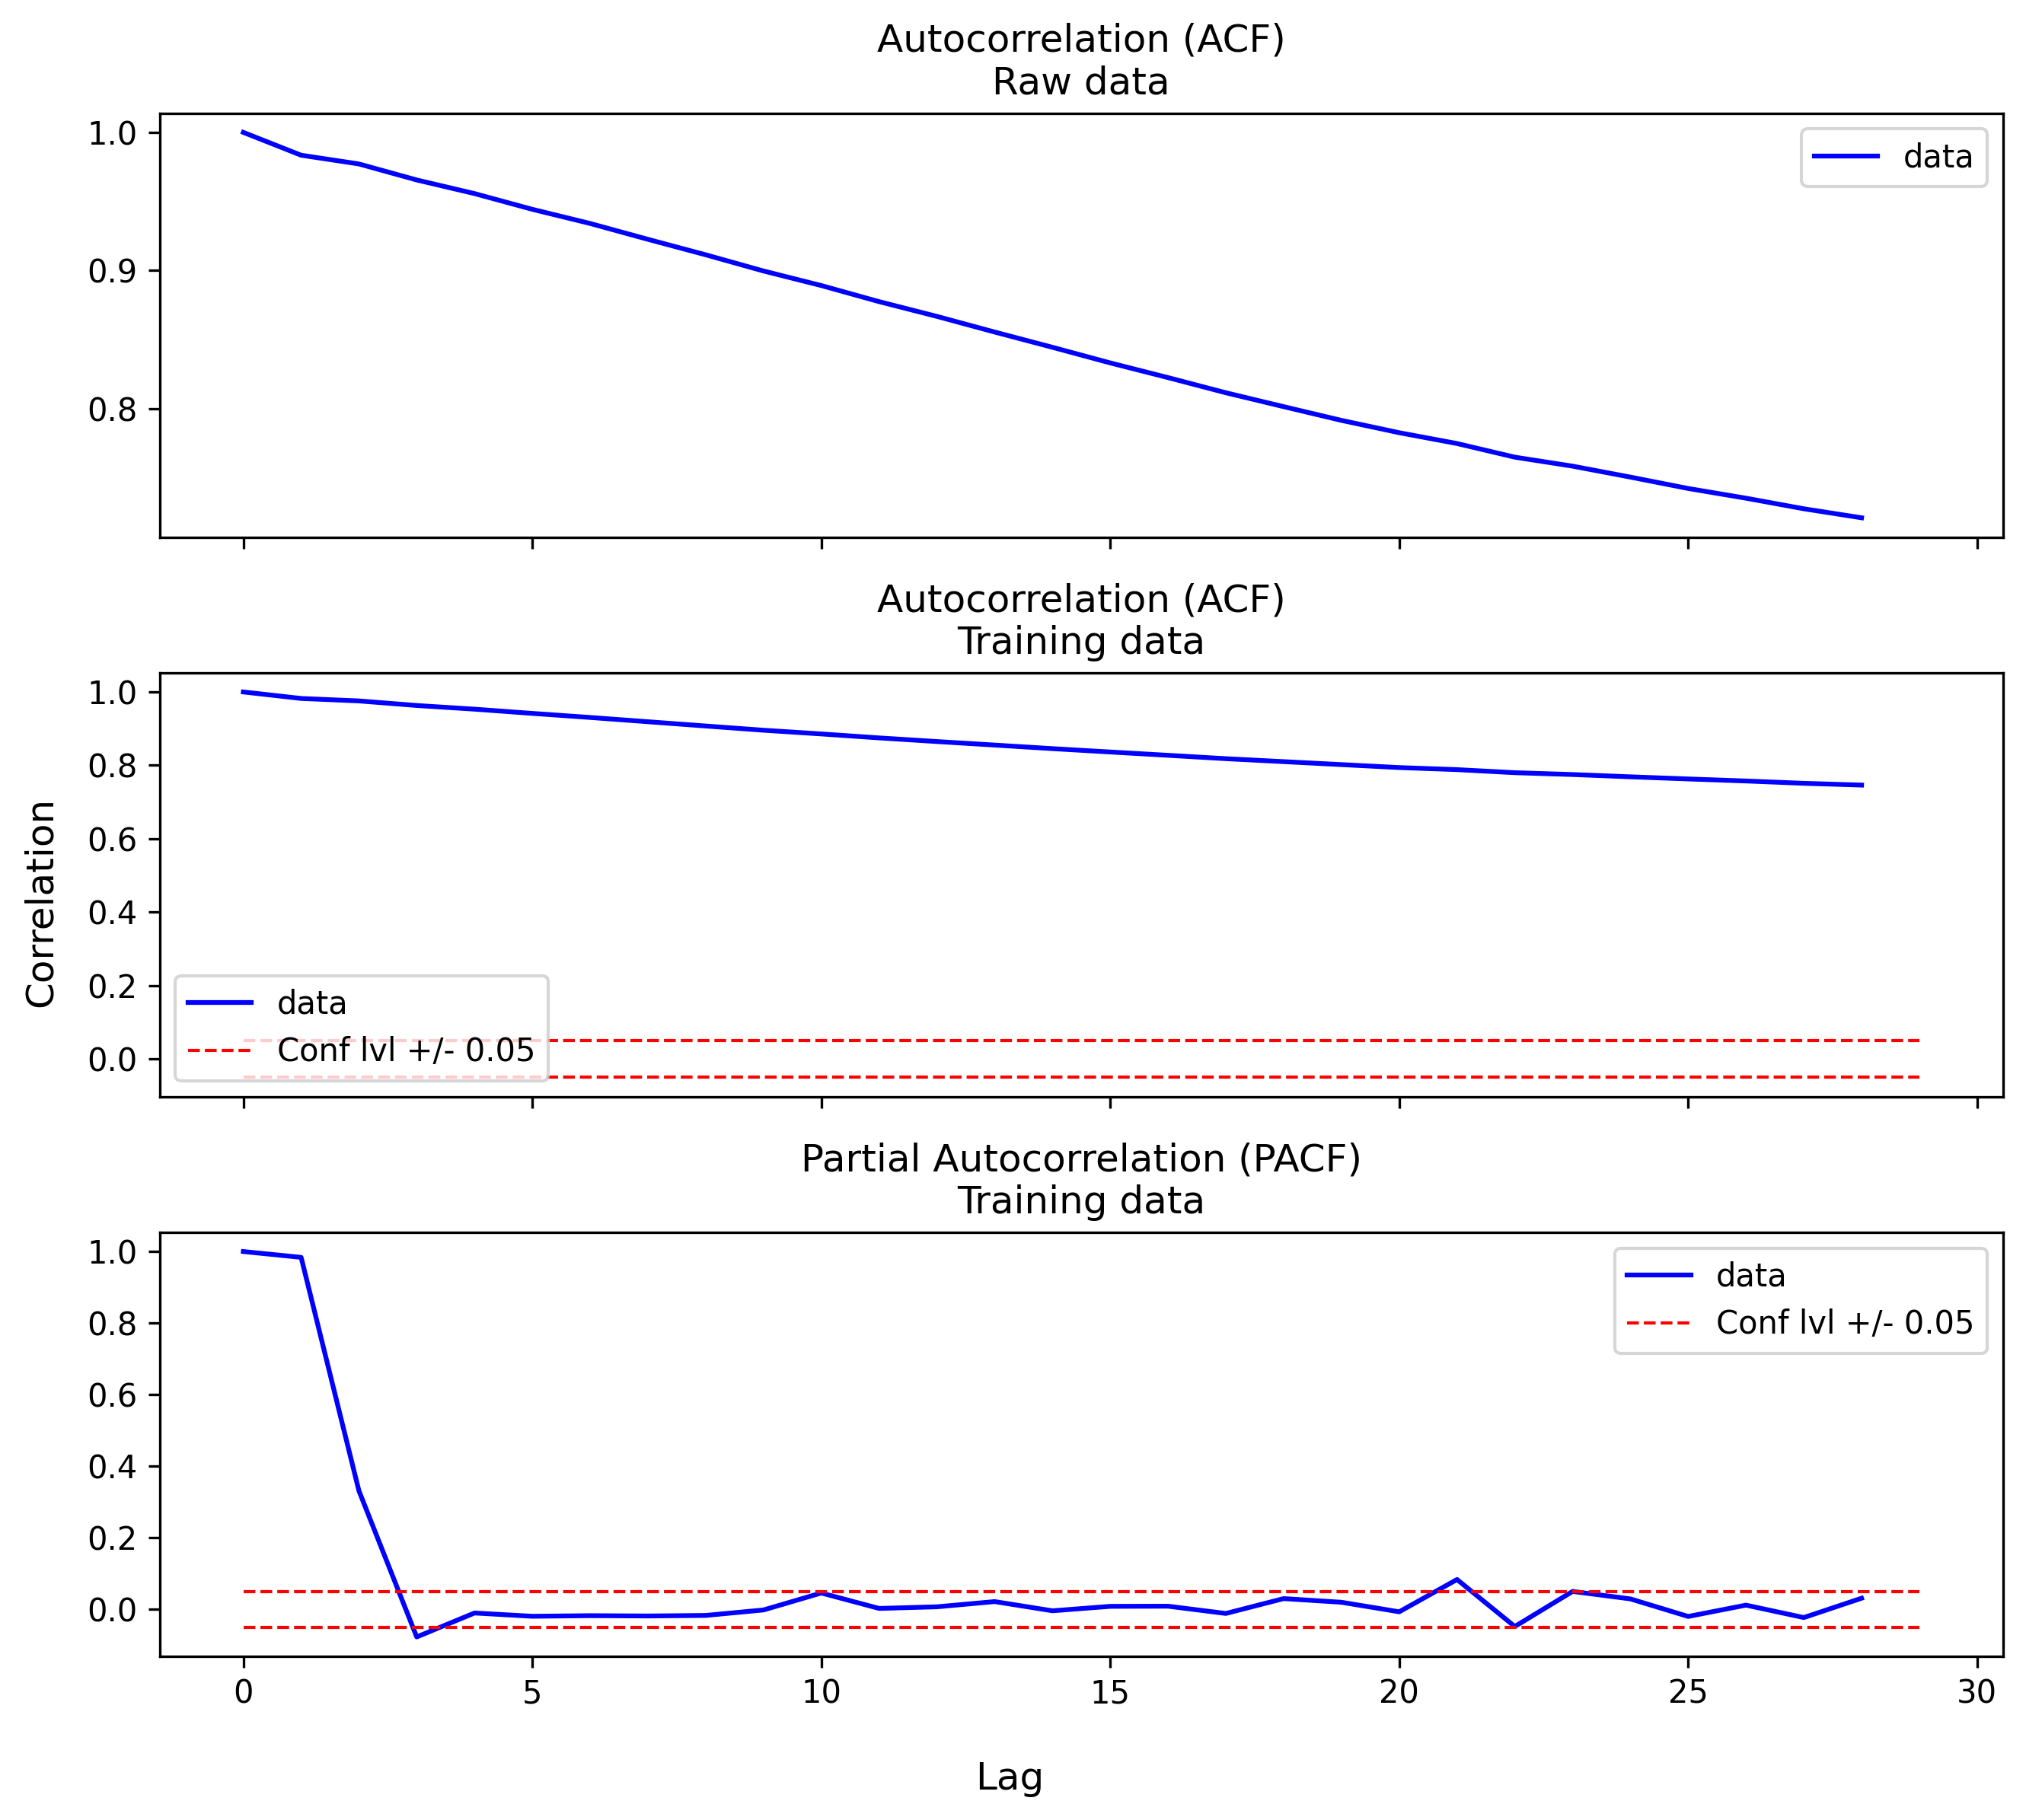

In [29]:
# autocorrelation/partial autocorrleation
fig, ax = plt.subplots(3,1, figsize = (9, 8), sharex=True, sharey=False)
acf_plot(data=df, target='Revenue', ax=ax, i=0, conf=False,
         title='Autocorrelation (ACF)\nRaw data')
acf_plot(data=train, target='Revenue', ax=ax, i=1, conf=True,
         title='Autocorrelation (ACF)\nTraining data')
pacf_plot(data=train, target='Revenue', ax=ax, i=2, conf=True,
          title='Partial Autocorrelation (PACF)\nTraining data')
fig.supxlabel('Lag') # common x label
fig.supylabel('Correlation') # common y label
title = 'Autocorrelation - Partial Autocorrelation Plots'
save_fig(title)

## decompose cleaned data

https://machinelearningmastery.com/decompose-time-series-data-trend-seasonality/

Saving figure: Decomposition on cleaned data


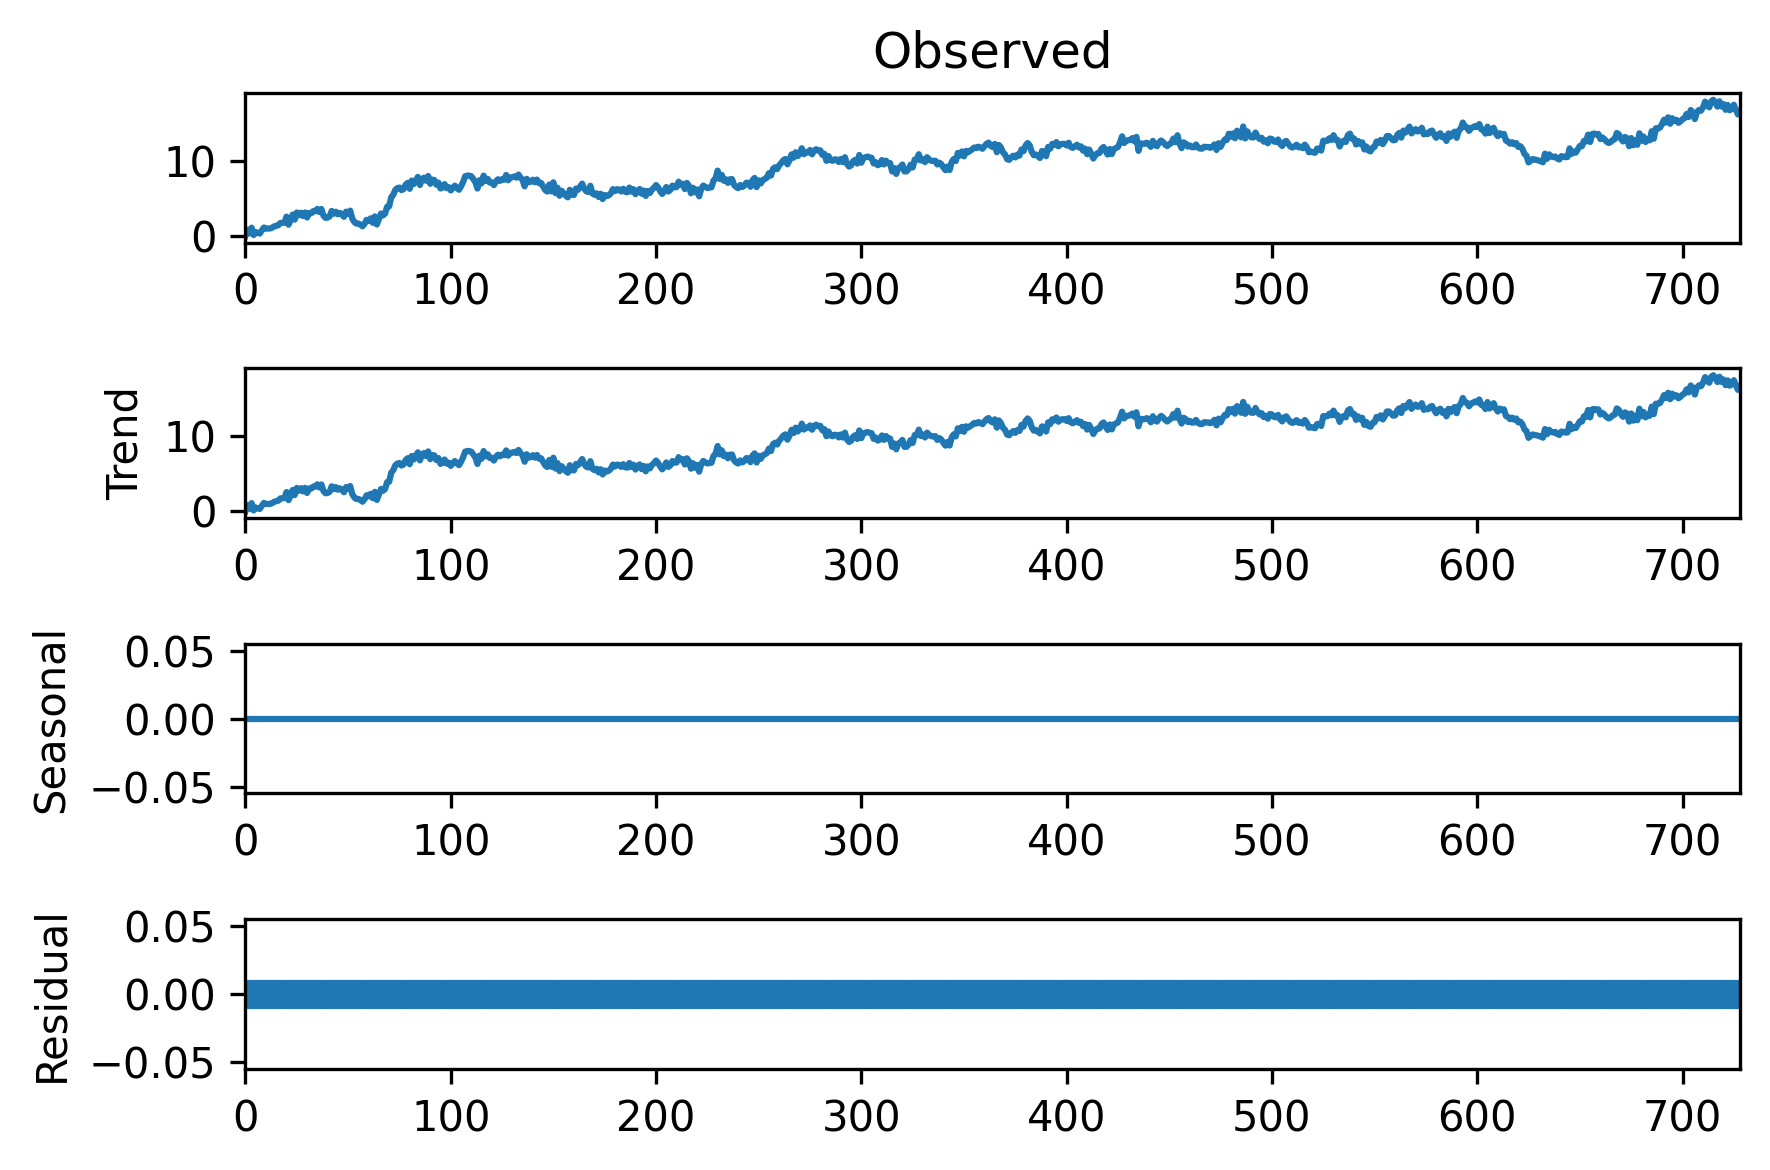

In [30]:
# decompose cleaned data - additive
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df['Revenue'].values, 
            model='additive', period=1)
result.plot()
title = 'Decomposition on cleaned data'
save_fig(title)

## auto find p,d,q values

In [31]:
# use auto arima to find best p,d,q
from pmdarima import auto_arima
import warnings
warnings.filterwarnings('ignore')
pdq = auto_arima(train['Revenue'], 
        trace=True, supress_warings=True)
#pdq.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=940.179, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1111.572, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=935.885, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=974.705, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1110.709, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=937.557, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=937.606, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=938.427, Time=0.22 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=937.012, Time=0.02 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 0.641 seconds


## final model

### model (1,1,0) on original data

In [35]:
# create final model 
model = ARIMA(df['Revenue'], order=(1,1,0))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                Revenue   No. Observations:                  729
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -490.019
Date:                Fri, 22 Jul 2022   AIC                            984.039
Time:                        18:06:43   BIC                            993.219
Sample:                    01-02-2020   HQIC                           987.581
                         - 12-30-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4677      0.033    -14.214      0.000      -0.532      -0.403
sigma2         0.2249      0.013     17.706      0.000       0.200       0.250
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 2.22
Prob(Q):                              0.99   Prob(JB):                         0.33
Heteroskedasticity (H):               1.02   Skew:                            -0.02
Prob(H) (two-sided):                  0.89   Kurtosis:                         2.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### make a forecast outside of sample data

In [46]:
# make forecast outside of sample
results.forecast(30)

2021-12-31    16.421560
2022-01-01    16.514746
2022-01-02    16.471162
2022-01-03    16.491547
2022-01-04    16.482012
2022-01-05    16.486472
2022-01-06    16.484386
2022-01-07    16.485362
2022-01-08    16.484905
2022-01-09    16.485119
2022-01-10    16.485019
2022-01-11    16.485066
2022-01-12    16.485044
2022-01-13    16.485054
2022-01-14    16.485049
2022-01-15    16.485051
2022-01-16    16.485050
2022-01-17    16.485051
2022-01-18    16.485051
2022-01-19    16.485051
2022-01-20    16.485051
2022-01-21    16.485051
2022-01-22    16.485051
2022-01-23    16.485051
2022-01-24    16.485051
2022-01-25    16.485051
2022-01-26    16.485051
2022-01-27    16.485051
2022-01-28    16.485051
2022-01-29    16.485051
Freq: D, Name: predicted_mean, dtype: float64

In [36]:
df.tail(30)

,Revenue,Year,Month,rolling_mean,rolling_std
Date,,,,,
2021-12-01,15.269829,2021,12,13.823538,1.237132
2021-12-02,15.563935,2021,12,13.910287,1.265516
2021-12-03,15.709684,2021,12,14.013880,1.281814
2021-12-04,16.270576,2021,12,14.116431,1.335889
2021-12-05,15.864648,2021,12,14.211088,1.356333
2021-12-06,16.791981,2021,12,14.372161,1.366645
2021-12-07,16.446698,2021,12,14.485433,1.393714
2021-12-08,15.576833,2021,12,14.601569,1.331220
2021-12-09,16.517375,2021,12,14.727188,1.328162


In [37]:
# prediction for last 30-days
predictions = results.predict(start=700, end=730, type='levels')
print(predictions)

2021-12-02    15.180075
2021-12-03    15.426378
2021-12-04    15.641515
2021-12-05    16.008239
2021-12-06    16.054506
2021-12-07    16.358255
2021-12-08    16.608191
2021-12-09    15.983680
2021-12-10    16.077471
2021-12-11    16.664033
2021-12-12    16.739706
2021-12-13    16.937485
2021-12-14    17.552008
2021-12-15    17.673176
2021-12-16    17.297958
2021-12-17    17.573268
2021-12-18    18.058451
2021-12-19    17.949332
2021-12-20    17.493108
2021-12-21    17.624209
2021-12-22    17.581623
2021-12-23    17.430360
2021-12-24    17.178094
2021-12-25    17.160983
2021-12-26    17.087638
2021-12-27    16.851916
2021-12-28    17.229164
2021-12-29    17.124970
2021-12-30    16.479569
2021-12-31    16.421560
2022-01-01    16.514746
Freq: D, Name: predicted_mean, dtype: float64


Saving figure: Final Model Predictions vs Test Data


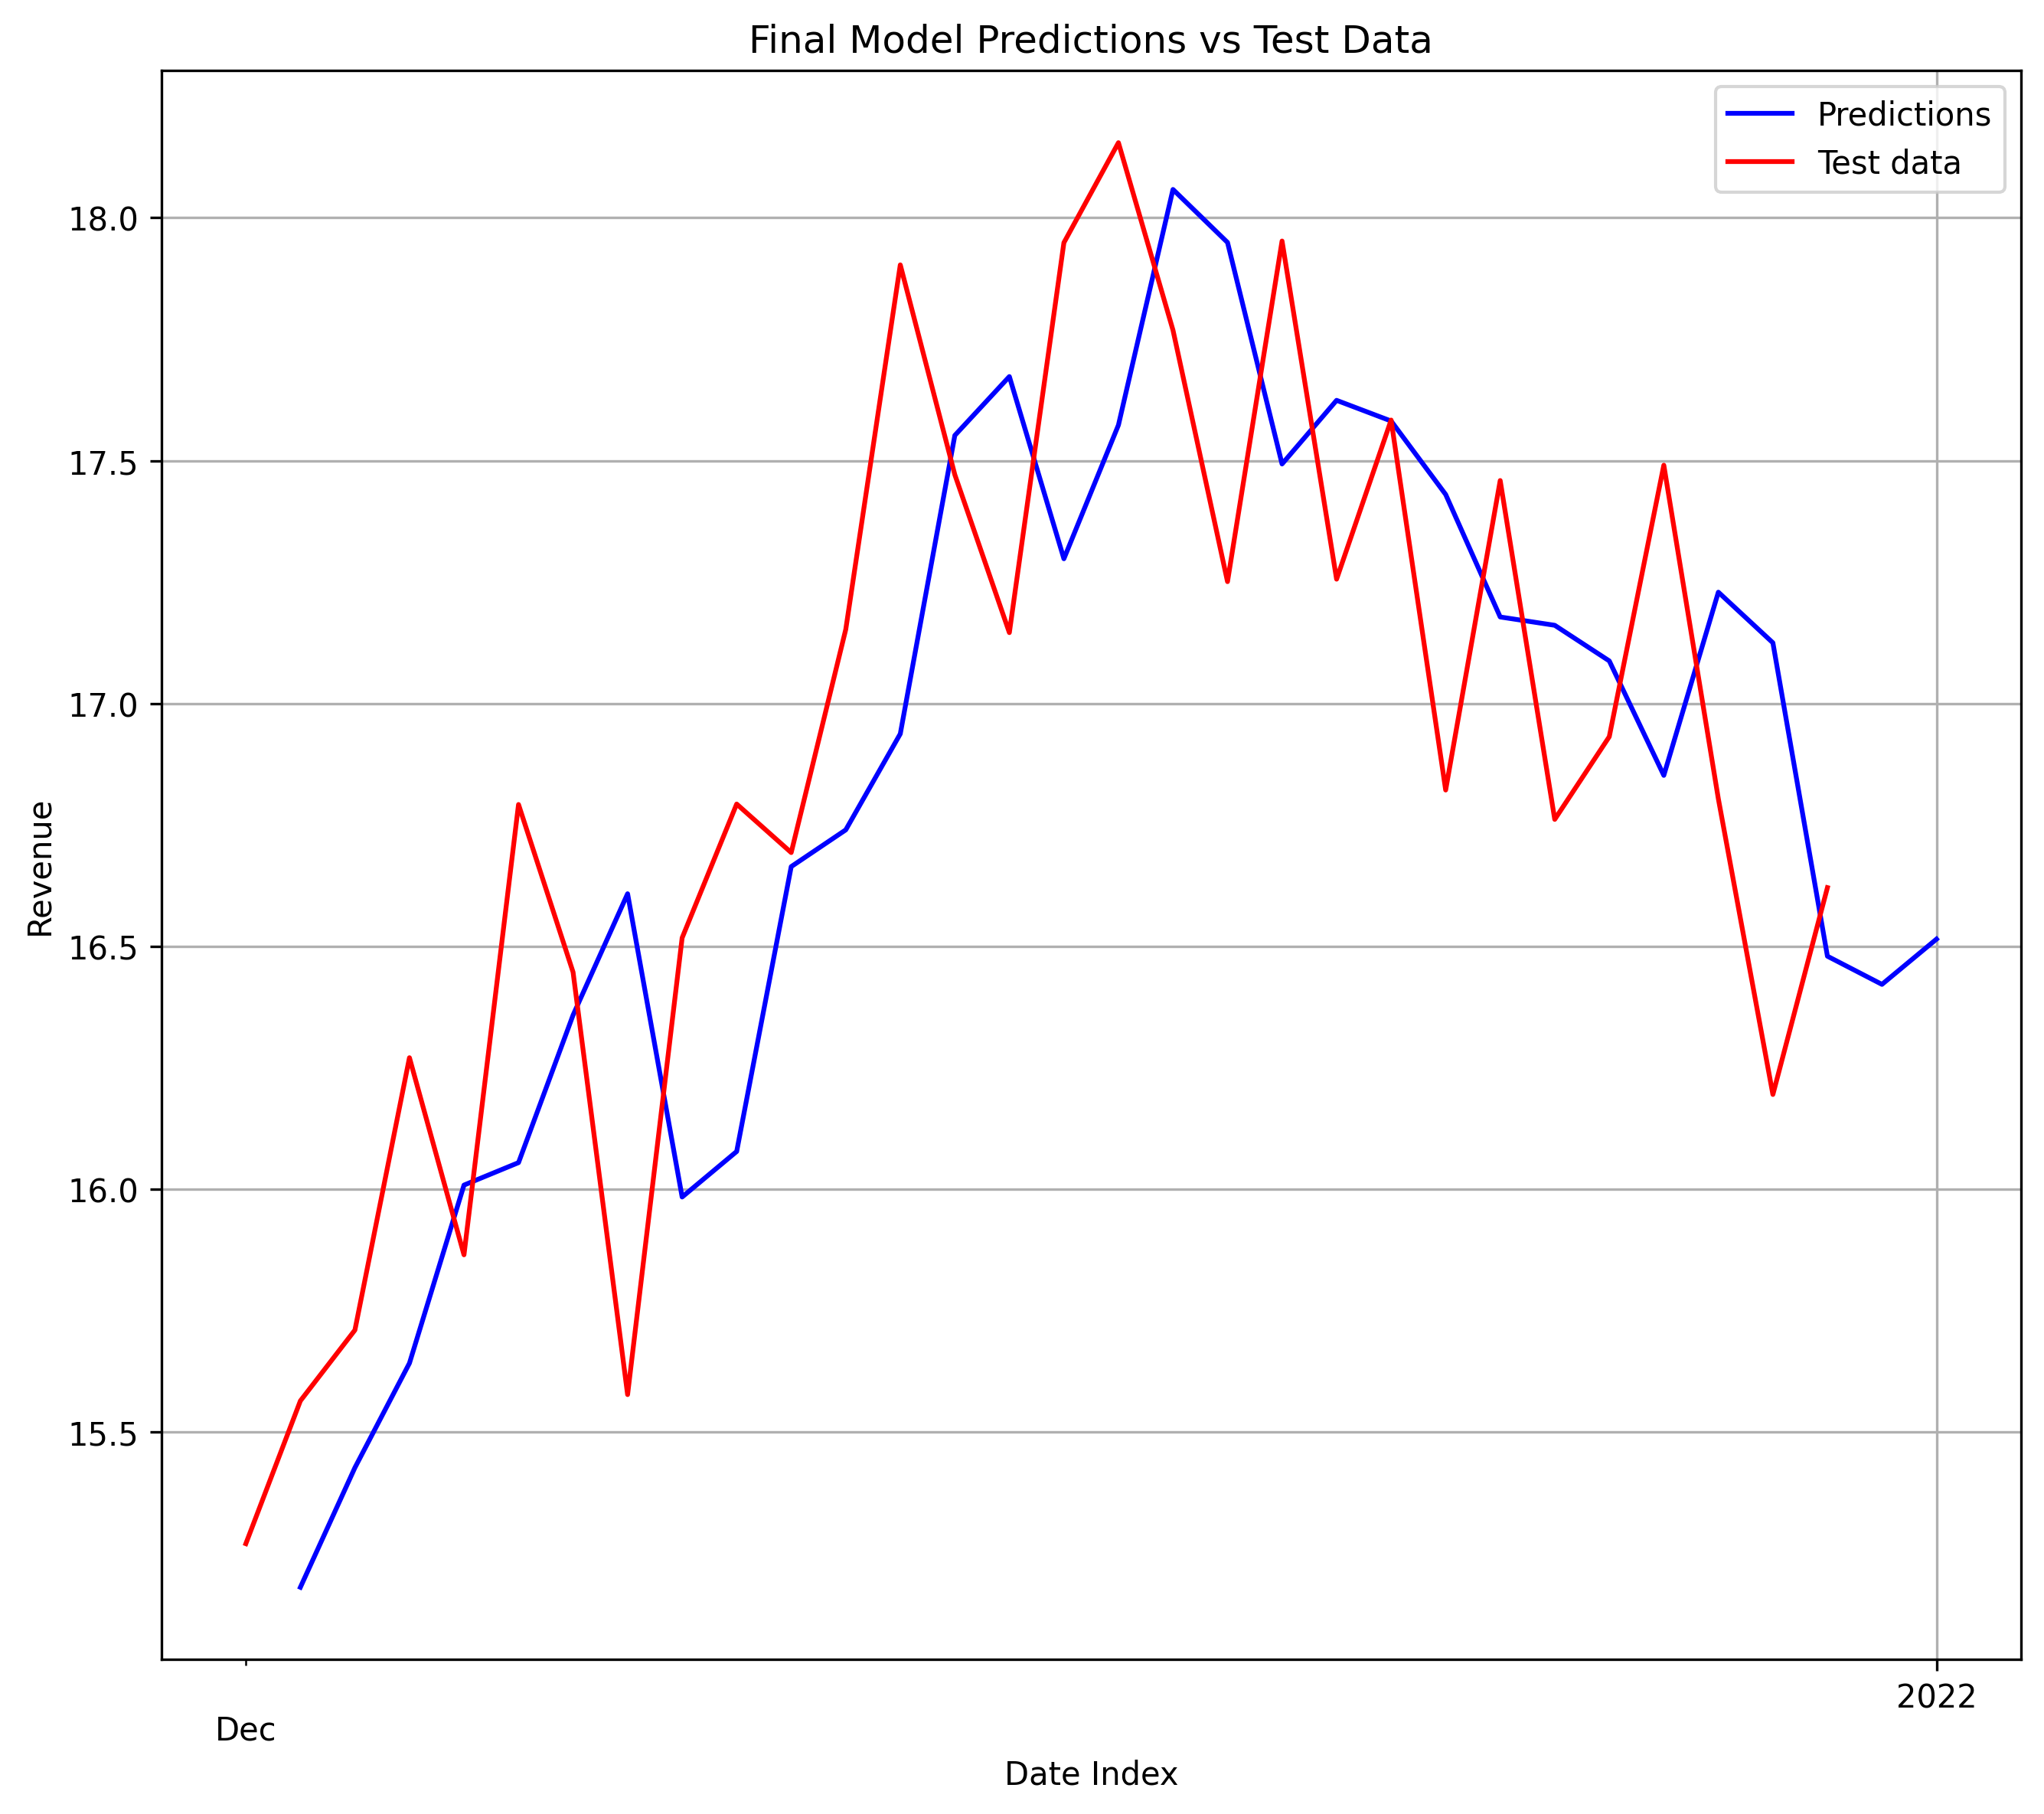

In [43]:
fig, ax = plt.subplots(1,1, figsize = (9, 8))
pred = plt.plot(predictions, "b", label='Predictions')
plt.plot(test['Revenue'], "r", label='Test data')
plt.xlabel("Date Index")
plt.ylabel("Revenue")
title = 'Final Model Predictions vs Test Data'
plt.legend()
plt.grid()
import matplotlib.dates as mdates
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_minor_locator(mdates.MonthLocator())
ax.xaxis.set_minor_formatter(mdates.DateFormatter('\n%b'))
plt.title(title)
save_fig(title) 